In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import os

def fetch_yahoo_history_scrape(symbol, start_epoch, end_epoch, save_prefix="scraped_data"):
    """
    Scrape historical stock data from Yahoo Finance using Selenium.

    Parameters:
    - symbol (str): e.g., '^NSEI', 'AAPL', 'RELIANCE.NS'
    - start_epoch (int): Start time in Unix timestamp
    - end_epoch (int): End time in Unix timestamp
    - save_prefix (str): Filename prefix

    Returns:
    - df (pd.DataFrame): Parsed table data
    """

    # Construct URL
    base_url = "https://finance.yahoo.com/quote/{}/history".format(symbol)
    params = f"?period1={start_epoch}&period2={end_epoch}&interval=1d&filter=history&frequency=1d"
    full_url = base_url + params

    # Set headless browser options
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920,1080")
    options.add_argument("start-maximized")
    options.add_argument("disable-infobars")
    options.add_argument("--disable-extensions")

    # Start Selenium
    driver = webdriver.Chrome(options=options)
    driver.get(full_url)
    time.sleep(5)  # Allow JS to render

    # Parse page source
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find('table')

    if not table:
        driver.quit()
        raise ValueError("Failed to locate data table. The page structure may have changed.")

    # Extract headers
    headers = [th.text.strip() for th in table.find_all('th')]

    # Extract rows
    rows = []
    for tr in table.find_all('tr')[1:]:
        cols = [td.text.strip() for td in tr.find_all('td')]
        if len(cols) == len(headers):  # Ensure only complete rows are added
            rows.append(cols)

    # Build DataFrame
    df = pd.DataFrame(rows, columns=headers)

    # Cleanup driver
    driver.quit()

    # Save
    clean_symbol = symbol.replace("^", "").replace(".", "_")
    # csv_file = f"{save_prefix}_{clean_symbol}.csv"
    xlsx_file = f"{clean_symbol}.xlsx"
    # df.to_csv(csv_file, index=False)
    df.to_excel(xlsx_file, index=False)

    print(f"Scraping complete. Files saved:\n- {xlsx_file}")
    return df


# NSEI (Nifty 50), from Oct 2007 to May 2025 (timestamps)
start_ts = 1190000700   # ~Oct 2007
end_ts = 1746202453     # ~May 2025

sym="SBIN.NS"
df = fetch_yahoo_history_scrape(sym, start_ts, end_ts)


Scraping complete. Files saved:
- SBIN_NS.xlsx


In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [10]:
# AAPL = pd.read_excel("AAPL.xlsx")
# TSLA = pd.read_excel("TSLA.xlsx")
# GOOG = pd.read_excel("GOOG.xlsx")
# MSFT = pd.read_excel("MSFT.xlsx")
# AMZN = pd.read_excel("AMZN.xlsx")
# Bajaj_F = pd.read_excel("BAJFINANCE_NS.xlsx")
SBIN = pd.read_excel("SBIN_NS.xlsx")

In [11]:
TSLA=SBIN

In [12]:
TSLA["Date"] = pd.to_datetime(TSLA["Date"],format="%b %d, %Y")
TSLA = TSLA.sort_values(by='Date',ascending=True)
# AAPL=AAPL[["Date","Open","Close"]]


In [13]:
TSLA

,Date,Open,High,Low,Close Close price adjusted for splits.,Adj Close Adjusted close price adjusted for splits and dividend and/or capital gain distributions.,Volume
4342,2007-09-17,154.27,158.04,154.27,155.27,126.48,"8,372,077"
4341,2007-09-18,157.57,160.67,154.45,159.92,130.27,"17,483,906"
4340,2007-09-19,163.70,167.47,163.70,166.97,136.02,"19,620,191"
4339,2007-09-20,169.72,169.72,165.32,166.02,135.24,"10,514,542"
4338,2007-09-21,165.97,173.60,165.40,170.52,138.91,"10,646,092"
...,...,...,...,...,...,...,...
4,2025-04-25,815.00,819.00,787.00,798.65,798.65,"13,131,038"
3,2025-04-28,798.65,822.80,797.40,817.35,817.35,"11,317,611"
2,2025-04-29,820.00,829.00,809.00,812.55,812.55,"11,283,059"
1,2025-04-30,811.50,811.50,784.50,788.65,788.65,"25,635,764"


In [14]:
training_cutoff_date="2023-11-30"
validation_cutoff_date='2025-03-18'
# testing_cutoff_date='2025-03-19'
training_data=TSLA[TSLA['Date'] < training_cutoff_date]
validation_data=TSLA[(TSLA['Date']>=training_cutoff_date)&(TSLA["Date"]<validation_cutoff_date)]
# testing_data=AAPL[(AAPL['Date']>=validation_cutoff_date)&(AAPL["Date"]<=testing_cutoff_date)]
# testing_data

In [15]:
training_data.index=training_data["Date"]
training_data=training_data.iloc[:,4]
validation_data.index=validation_data["Date"]
validation_data=validation_data.iloc[:,4]


# training_data.index=training_data["Date"]
# training_data=training_data["Adj Close"]
# validation_data.index=validation_data["Date"]
# validation_data=validation_data["Adj Close"]

# testing_data.index=testing_data["Date"]
# testing_data=testing_data["Adj Close"]

In [16]:
from sklearn.preprocessing import MinMaxScaler
import joblib
# sym="BAJFINANCE.NS"

min_max = MinMaxScaler(feature_range=(0, 1))
training_data = training_data.replace({',': ''}, regex=True).astype(float)
validation_data = validation_data.replace({',': ''}, regex=True).astype(float)
train_scaled = min_max.fit_transform(training_data.values.reshape(-1, 1))
joblib.dump(min_max, f'scalers/{sym}_scaler.save')
val_scaled = min_max.transform(validation_data.values.reshape(-1, 1))
# test_scaled= min_max.transform(testing_data.values.reshape(-1, 1))



In [17]:
val_scaled.shape

(320, 1)

In [18]:
time_steps = 10

x_train=[]
y_train=[]
x_val=[]
y_val=[]
# x_test=[]
# y_test=[]
for i in range(time_steps, train_scaled.shape[0]):
    x_train.append(train_scaled[i-time_steps : i])
    y_train.append(train_scaled[i, 0])
for i in range(time_steps, val_scaled.shape[0]):
    x_val.append(val_scaled[i-time_steps : i])
    y_val.append(val_scaled[i, 0])
# for i in range(time_steps, test_scaled.shape[0]):
#     x_test.append(test_scaled[i-time_steps : i])
#     y_test.append(test_scaled[i, 0])

x_test=x_val[160:]
x_val=x_val[:160]
y_test=y_val[160:]
y_val=y_val[:160]




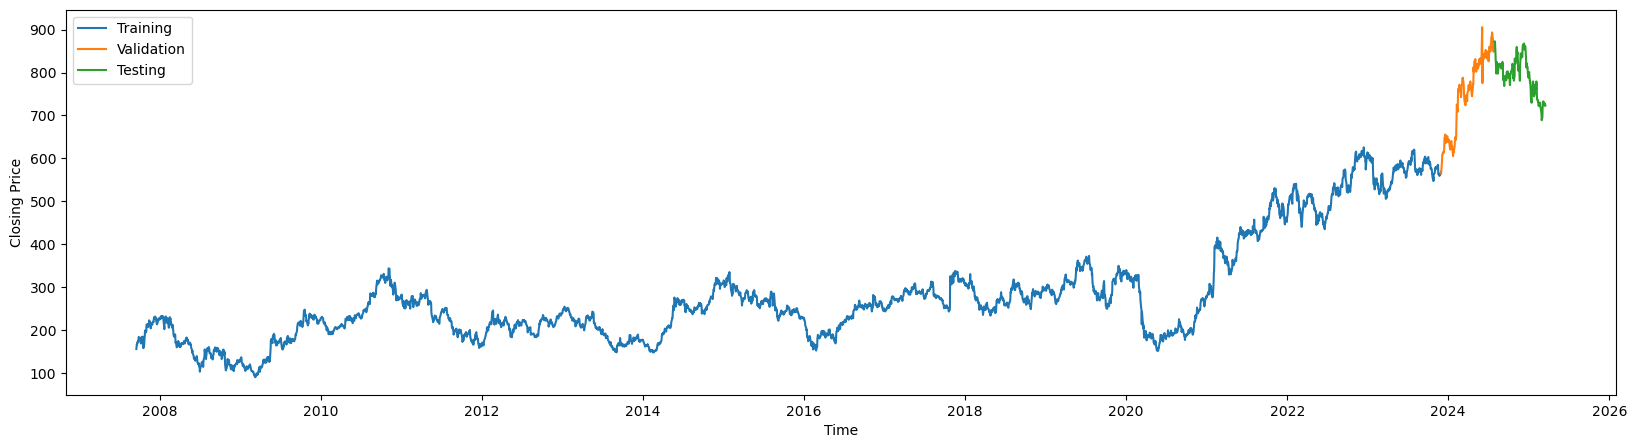

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(training_data.index, training_data, label = 'Training')
plt.plot(validation_data.index[:160], validation_data[:160],label = 'Validation')
plt.plot(validation_data.index[160:], validation_data[160:],label = 'Testing')
# plt.plot(AAPL['Date'][AAPL['Date'] >= training_cutoff_date][:-8],AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [20]:
import numpy as np
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val=np.array(x_val)
y_val=np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Multiply, Softmax

def model(x_train):
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (x_train.shape[1], 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(1, activation = tf.nn.leaky_relu)
                                      ])
  return model




In [22]:
model=model(x_train)

W0000 00:00:1746208382.664349  209659 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,801 (2.09 MB)

 Trainable params: 547,801 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

None


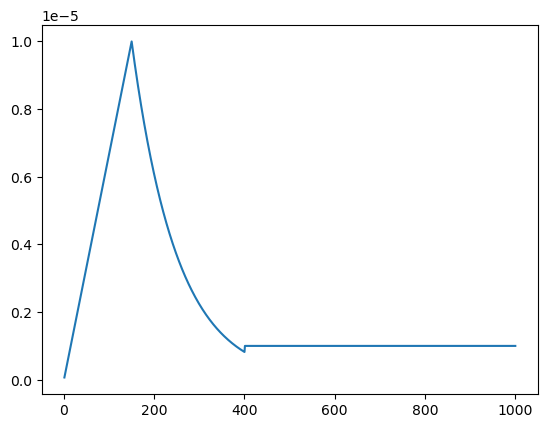

In [24]:
import tensorflow as tf
import os
import datetime
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch):

  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150)
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)

  return lrate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1,1001, 1)]
plt.plot(epochs, lrate)

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError(name="MSE")])

In [26]:
model

<Sequential name=sequential, built=True>

In [ ]:
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val),
                        callbacks=[callback,tensorboard_callback])

Epoch 1/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - MSE: 0.1773 - loss: 0.1773 - val_MSE: 1.6225 - val_loss: 1.6225 - learning_rate: 0.0000e+00
Epoch 2/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - MSE: 0.1716 - loss: 0.1716 - val_MSE: 1.6221 - val_loss: 1.6221 - learning_rate: 6.6667e-08
Epoch 3/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - MSE: 0.1801 - loss: 0.1801 - val_MSE: 1.6212 - val_loss: 1.6212 - learning_rate: 1.3333e-07
Epoch 4/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - MSE: 0.1800 - loss: 0.1800 - val_MSE: 1.6200 - val_loss: 1.6200 - learning_rate: 2.0000e-07
Epoch 5/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - MSE: 0.1760 - loss: 0.1760 - val_MSE: 1.6183 - val_loss: 1.6183 - learning_rate: 2.6667e-07
Epoch 6/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - MSE: 0.1808 - loss: 0.1808 - val_MSE: 1.6155 - val_loss: 1.6155 - learning_rate: 3.3333e-07
Epoch 7/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - MSE: 0.1761 - loss: 0.1761 - val_MSE: 1.6042 - va

In [ ]:
model.save(f"{sym}.keras")

In [ ]:
history_dict = history.history
loss = history_dict["loss"]
root_mean_squared_error = history_dict["MSE"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_MSE"]

epochs = range(1, len(loss) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [ ]:
prediction = model.predict(x_test)

In [ ]:
scaled_pred=min_max.inverse_transform(prediction)
scaled_y_test=min_max.inverse_transform(y_test.reshape(-1,1))

In [ ]:

y_test.reshape(-1,1).shape

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(training_data.index, training_data, label = 'Training')
plt.plot(validation_data.index[:160], validation_data[:160],label = 'Validation')
plt.plot(validation_data.index[160:],validation_data[160:],label = 'Testing Ground Truth')
# plt.plot(validation_data.index[170:], scaled_y_test,label = 'Testing Ground Truth')
plt.plot(validation_data.index[170:],scaled_pred, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(training_data.index, training_data, label = 'Training')
plt.plot(validation_data.index[:160], validation_data[:160],label = 'Validation')
plt.plot(validation_data.index[160:],validation_data[160:],label = 'Testing Ground Truth')
# plt.plot(validation_data.index[170:], min_max.inverse_transform(y_test.reshape(-1,1)),label = 'Testing Ground Truth')
plt.plot(validation_data.index[170:],scaled_pred, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [ ]:
rmse = math.sqrt(mean_squared_error(scaled_y_test,scaled_pred))
mape = np.mean(np.abs(scaled_pred - scaled_y_test)/np.abs(scaled_y_test))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape*100}')
from sklearn.metrics import r2_score
r2 = r2_score(scaled_y_test, scaled_pred)
print(f"R² score: {r2:.4f}")
